# Metrics Study

This notebook will focus on studying the results obtained from the tests done with both QA and QAOA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from Bio import Phylo
import re
from io import StringIO
import os

---
# QA

## RF distance

In [2]:
# Load the data

rf = pd.read_csv('RF-distance.csv')

rf.head()

grouped_df = rf.groupby("size", as_index=False)["RF"].mean()

# Renombrar la columna de RF para mayor claridad
grouped_df.rename(columns={"RF": "Media RF"}, inplace=True)


In [3]:
def f(x):
    return 0.35*x * np.log2(10.82*x)
    
print(f(39)*20)

2380.8414119256145


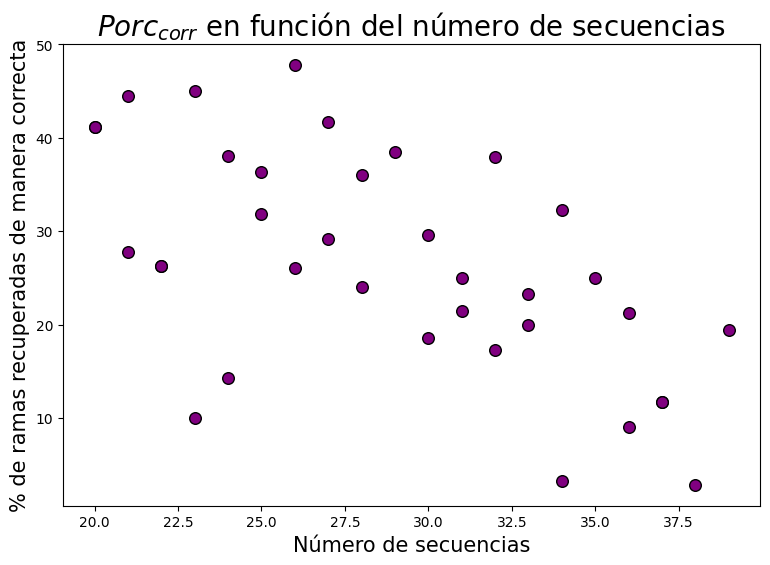

In [45]:
# Plot the data
plt.subplots(figsize=(9, 6))
plt.scatter(rf['size'], rf['RF'], edgecolor='k', color='purple', s=70)
# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)
plt.show()

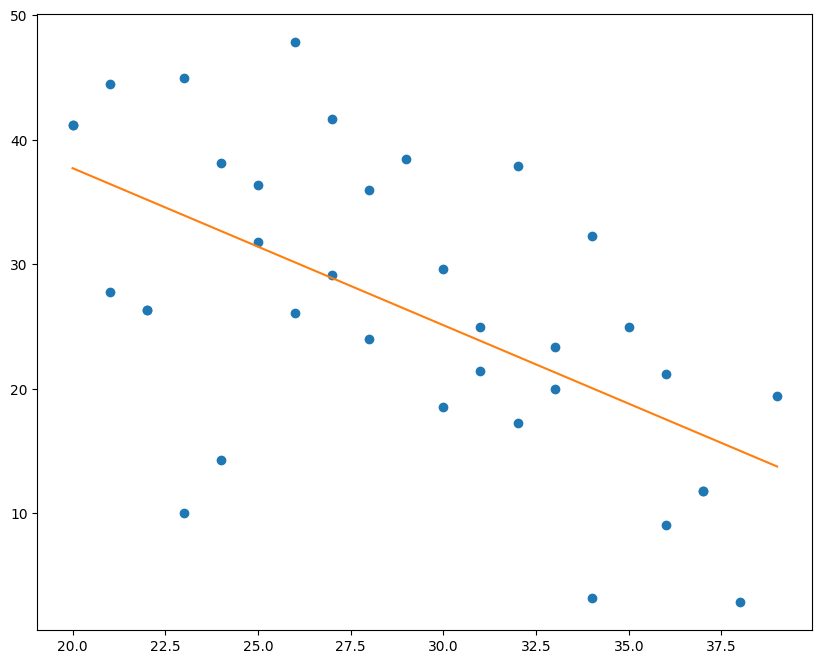

In [5]:
# Create a linear regression model and plot it with the cloud of points

from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(rf[['size']], rf['RF'])

fig,ax = plt.subplots(figsize=(10,8))

ax.plot(rf['size'], rf['RF'], 'o')

y_pred = model.predict(rf[['size']])

ax.plot(rf['size'], y_pred)

plt.show()

Then we can try to explain the outliers by using different tree parameters like average branch length or length of sequence. But first, let's identify outliers.

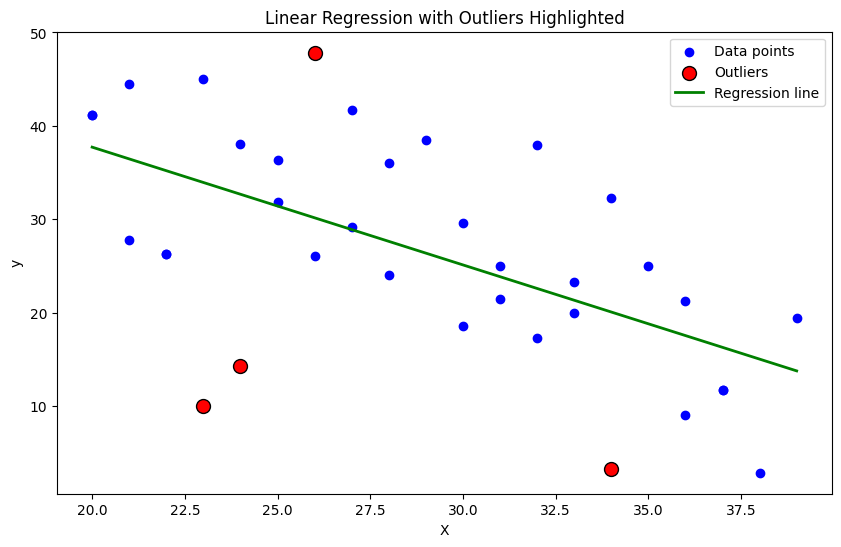

In [6]:
residuals = rf['RF'] - y_pred

# Identify outliers (using z-scores)
threshold = 1.75  # Customize the z-score threshold
outlier_mask = np.abs(zscore(residuals)) > threshold

# Plot the data points and outliers
plt.figure(figsize=(10, 6))
plt.scatter(rf['size'], rf['RF'], label='Data points', color='blue')
plt.scatter(rf['size'][outlier_mask], rf['RF'][outlier_mask], label='Outliers', color='red', edgecolor='k', s=100)
plt.plot(rf['size'], y_pred, label='Regression line', color='green', linewidth=2)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Linear Regression with Outliers Highlighted')
plt.show()

In [7]:
# Median of all rf
median_rf = rf['RF'].median()
print(f'Median of all RF: {median_rf}')

# Mean of all rf
mean_rf = rf['RF'].mean()
print(f'Mean of all RF: {mean_rf}')

Median of all RF: 26.205
Mean of all RF: 26.547222222222224


## Time

In [8]:
time = pd.read_csv('timer.csv')
# time_table = time.groupby('size')['time'].mean().reset_index()
# time_table['time'] = time_table['time']/1000
# time_table['Media RF'] = grouped_df['Media RF'].values

# print(time_table.to_latex(index=False,
#     float_format="%.2f",
#     caption="Métricas medias por tamaño",
#     label="tab:metricas_qa"))

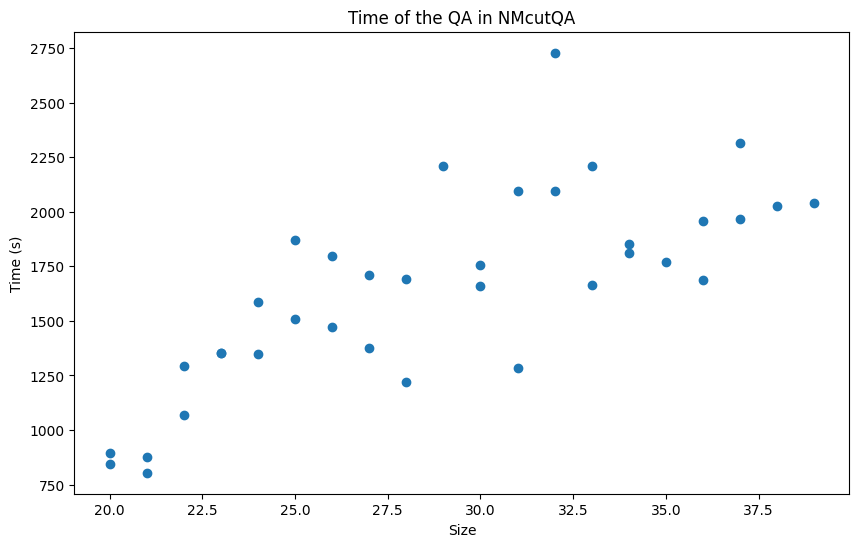

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(time['size'], time['time'], 'o')
plt.xlabel('Size')
plt.ylabel('Time (s)')
plt.title('Time of the QA in NMcutQA')
plt.show()

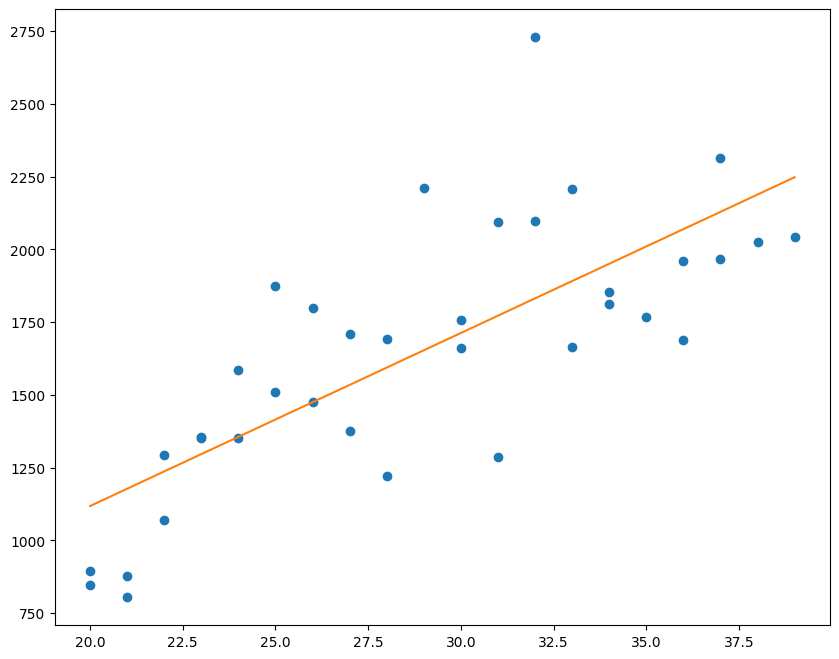

In [10]:
# Seems linear so, linear regression it is

model = LinearRegression()

model.fit(time[['size']], time['time'])

fig,ax = plt.subplots(figsize=(10,8))

X = time['size']
y = time['time']

ax.plot(X, y, 'o')

y_pred = model.predict(rf[['size']])

ax.plot(X, y_pred)

plt.show()

Text(0.5, 1.0, 'Approximate number of subproblems in NMcutQA')

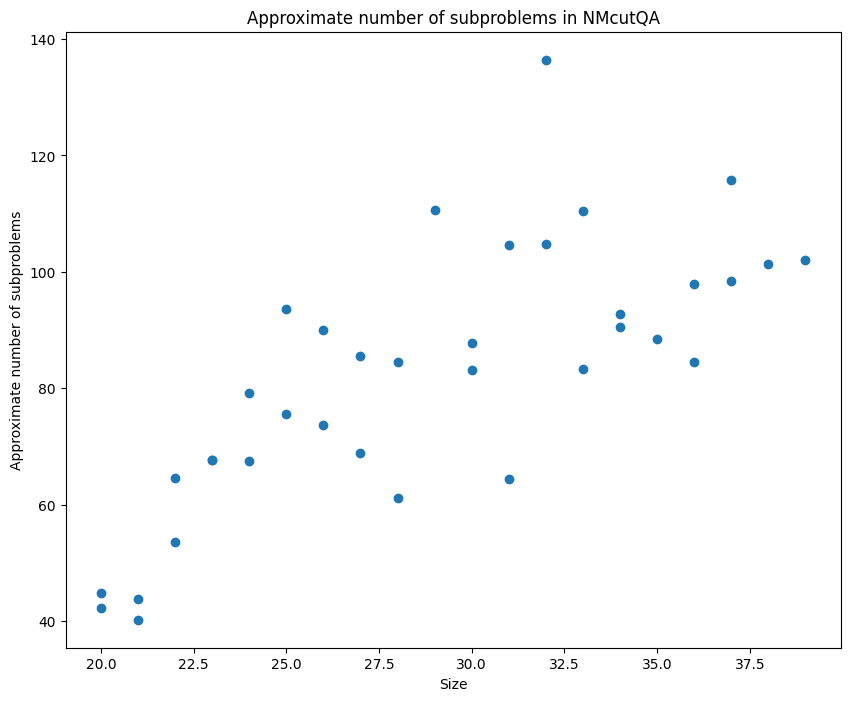

In [11]:
transform_time = time['time']/20

plt.subplots(figsize=(10,8))

plt.plot(time['size'], transform_time, 'o')
plt.xlabel('Size')
plt.ylabel('Approximate number of subproblems')

plt.title('Approximate number of subproblems in NMcutQA')

---
# QAOA

The QAOA, as espected, performed a lot worse than the QA, both in time and RF, let's see the few executions it made

## Time

In [20]:
qaoa_time = pd.read_csv('timer_qaoa.csv',dtype={'size':int,'time':float})
qaoa_time.head()

,size,name,time
0,20,matrix_10618.npy,1.885833e+07
1,20,matrix_41388.npy,1.871889e+07
2,21,matrix_45255.npy,2.240694e+07
3,21,matrix_48947.npy,2.013079e+07
4,10,matrix_28864.npy,9.110392e+04


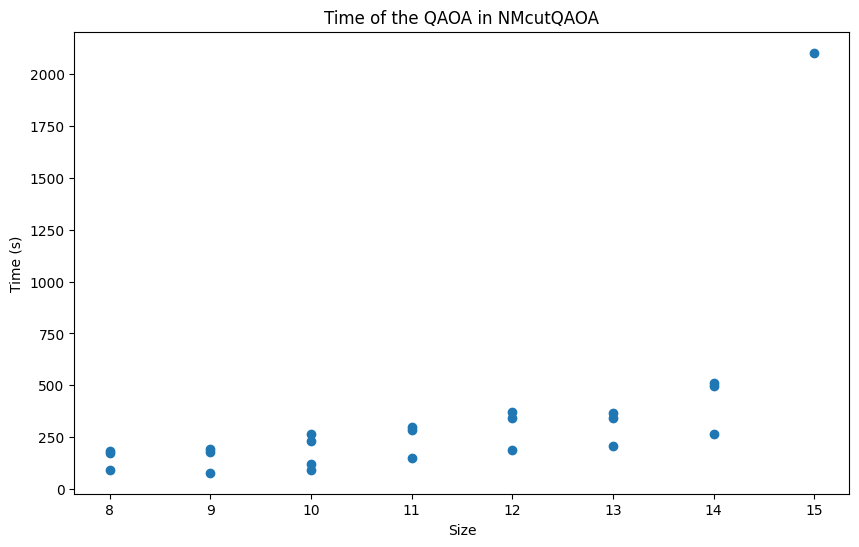

In [26]:
plt.figure(figsize=(10, 6))
filtered_time = qaoa_time[qaoa_time['time'] < 5000000]
plt.plot(filtered_time['size'], (filtered_time['time']/1000), 'o')
plt.xlabel('Size')
plt.ylabel('Time (s)')
plt.title('Time of the QAOA in NMcutQAOA')
plt.show()

In [14]:
hours = qaoa_time['time'].sum()/1000/3600
print(f'\033[1mThe whole ordeal (4 trees) took {hours} hours to execute\033[22m')

The whole ordeal (4 trees) took 28.936820084160697 hours to execute


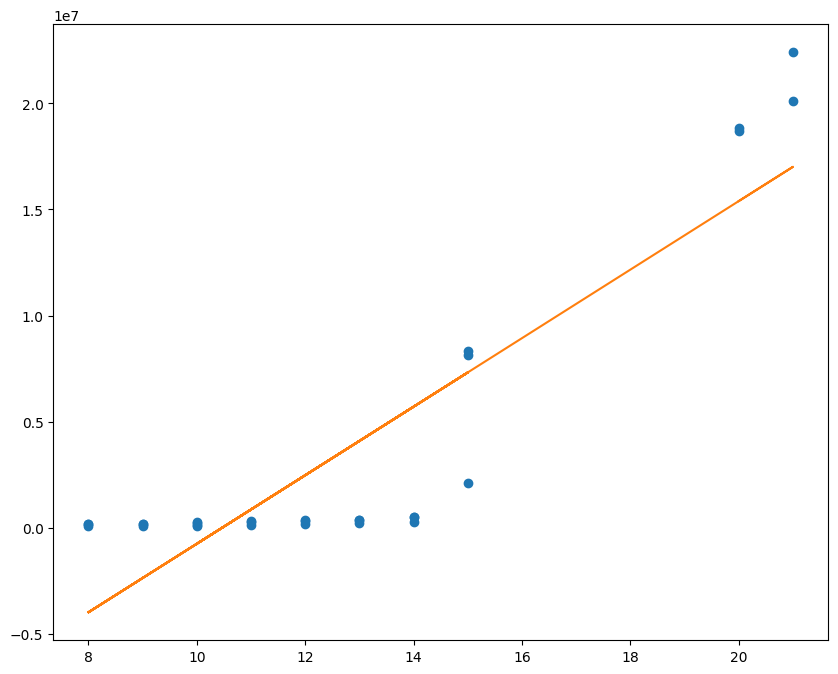

In [15]:
# Seems linear so, linear regression it is

model = LinearRegression()

model.fit(qaoa_time[['size']], qaoa_time['time'])

fig,ax = plt.subplots(figsize=(10,8))

X = qaoa_time['size']
y = qaoa_time['time']

ax.plot(X, y, 'o')

y_pred = model.predict(qaoa_time[['size']])

ax.plot(X, y_pred)

plt.show()

It's stupid to do statistics when having 2 or 3 values, so we can try to use smaller trees. Also:

## RF

In [34]:
rf_qaoa = pd.read_csv('RF-distance_qaoa.csv')
rf_qaoa.head()

grouped_df = rf_qaoa.groupby("size", as_index=False)["RF"].mean()
grouped_time = qaoa_time.groupby("size", as_index=False)["time"].mean()
grouped_df.insert(1, 'Tiempo (min)', (grouped_time['time'].values/1000)/60)
# Renombrar la columna de RF para mayor claridad
grouped_df.rename(columns={"RF": "Media RF",'size':'Tamaño'}, inplace=True)

print(grouped_df.to_latex(index=False,
    float_format="%.2f",
    caption="Media de RF por tamaño",
    label="tab:metricas_qaoa"))

\begin{table}
\caption{Media de RF por tamaño}
\label{tab:metricas_qaoa}
\begin{tabular}{rrr}
\toprule
Tamaño & Tiempo (min) & Media RF \\
\midrule
8 & 2.50 & 33.33 \\
9 & 2.53 & 11.11 \\
10 & 2.98 & 0.00 \\
11 & 4.07 & 8.33 \\
12 & 5.02 & 0.00 \\
13 & 5.11 & 6.67 \\
14 & 7.07 & 0.00 \\
15 & 103.39 & 0.00 \\
20 & 313.14 & 2.94 \\
21 & 354.48 & 8.33 \\
\bottomrule
\end{tabular}
\end{table}



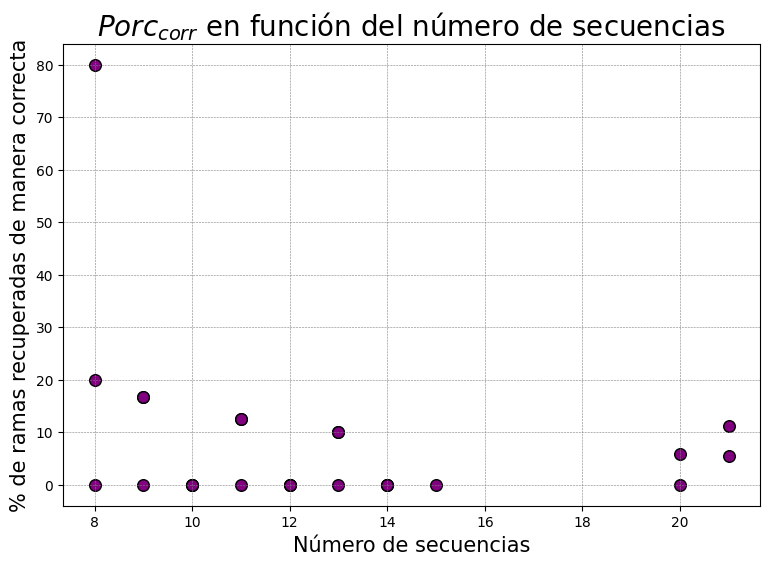

In [44]:
# Plot the data
plt.subplots(figsize=(9, 6))
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.scatter(rf_qaoa['size'], rf_qaoa['RF'], edgecolor='k', color='purple', s=70)
# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)

plt.show()

---
# Comparisons

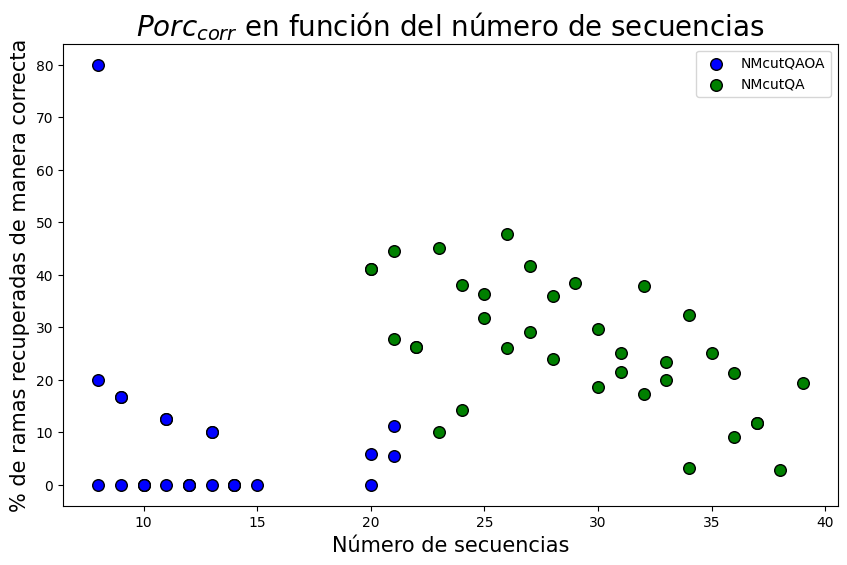

In [53]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(rf_qaoa['size'], rf_qaoa['RF'], edgecolor='k', color='blue', s=70,label='NMcutQAOA')
plt.scatter(rf['size'], rf['RF'], edgecolor='k', color='green', s=70,label='NMcutQA')
plt.legend()
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)
plt.show()

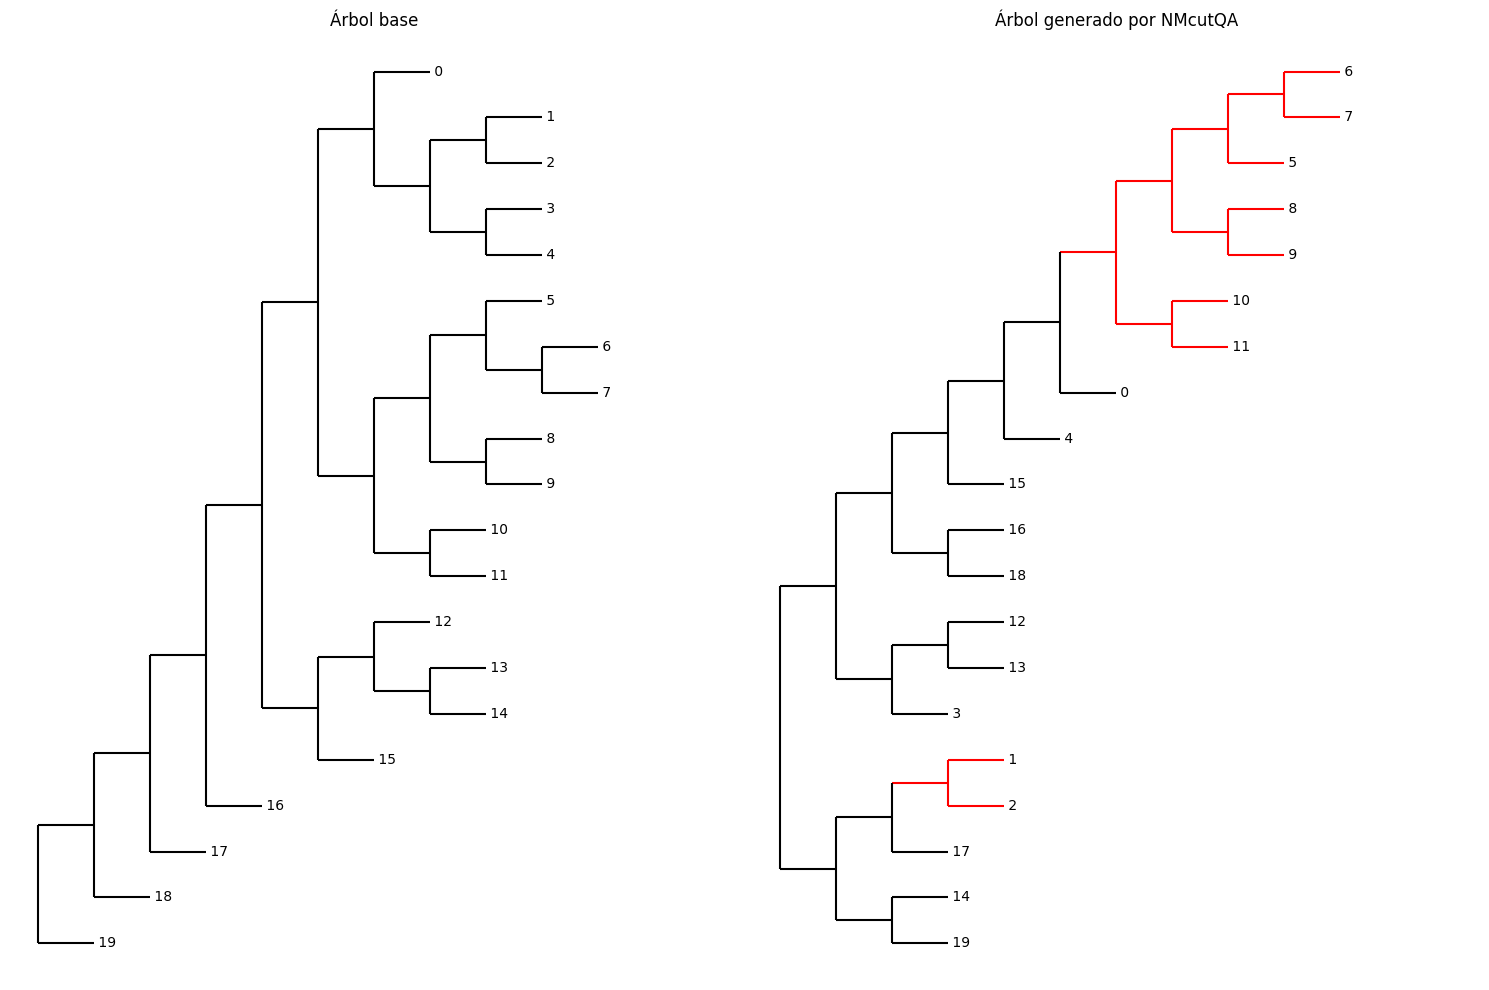

In [18]:
id = 10618
# get size from rf where id=id

size = rf[rf['id'] == str(id)]['size'].values[0]

with open(f'trees/{size}/qa_tree_{id}.newick','r') as file:
    qa_tree = file.read()
    
with open(f'trees/{size}/tree_best_{id}.newick','r') as file:
    biotree = file.read()
    
biotree = re.sub(r'taxon([0-9]+)',lambda match: str(int(match.group(1)) - 1),biotree)
biotree = re.sub(r':[0-9]\.[0-9]+(e-[0-9]+)*',r'',biotree)
# print(biotree)

tree1 = Phylo.read(StringIO(qa_tree), "newick")
# Phylo.draw(tree1)
tree2 = Phylo.read(StringIO(biotree), "newick")
# Phylo.draw(tree2)


# Function to get clade terminal taxa sets by name
def get_clade_taxa_sets(tree):
    return {
        frozenset(term.name for term in clade.get_terminals()) 
        for clade in tree.find_clades() if len(clade.get_terminals()) > 1 and len(clade.get_terminals()) != size  # Only internal clades
    }

# Find common clades based on their terminal taxa
common_taxa_sets = get_clade_taxa_sets(tree1).intersection(get_clade_taxa_sets(tree2))

# Function to color branches with common taxa in red
def color_common_branches(tree, common_taxa_sets):
    for clade in tree.find_clades():
        # Only consider internal clades (with more than one terminal)
        if len(clade.get_terminals()) > 1:
            # Check if the clade's terminals match a common set
            if frozenset(term.name for term in clade.get_terminals()) in common_taxa_sets:
                clade.color = "red"
            else:
                clade.color = "black"  # Default color for non-common branches

# Color the branches in the first tree
color_common_branches(tree1, common_taxa_sets)
# color_common_branches(tree2, common_taxa_sets)

# Create a figure with subplots (side by side)
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(15, 10))

# Plot the second tree
Phylo.draw(tree2, do_show=False, axes=axes1)
axes1.set_title("Árbol base")
plt.setp(axes1, xticks=[], yticks=[])  # Remove ticks
axes1.axis('off')  # Remove axes

# Plot the first tree
Phylo.draw(tree1, do_show=False, axes=axes2)
axes2.set_title("Árbol generado por NMcutQA")
plt.setp(axes2, xticks=[], yticks=[])  # Remove ticks
axes2.axis('off')  # Remove axes

# Show the plot
plt.tight_layout()
plt.show()

In [6]:
from PIL import Image, ImageDraw, ImageFont

# Load the saved image
image_path = "landscape.png"
img = Image.open(image_path)

# Define the new title properties
new_title = "Función objetivo en función de los parámetros de QAOA"
font_path = "arial.ttf"  # Adjust this to a valid font path on your system
font = ImageFont.truetype(font_path, size=20)
draw = ImageDraw.Draw(img)

# Calculate position for the title (top-center)
text_bbox = draw.textbbox((0, 0), new_title, font=font)  # Get bounding box of text
text_width = text_bbox[2] - text_bbox[0]
text_height = text_bbox[3] - text_bbox[1]
image_width, image_height = img.size
text_position = ((image_width - text_width) // 2, 10)  # Adjust Y-coordinate for positioning

# Add the new title to the image
draw.text(text_position, new_title, fill="black", font=font)

# Save the updated image
img.save("updated_graph_with_new_title.png")
img.show()

